# Imports Libraries and Tools

In [2]:
import os  # For directory and file operations
import numpy as np  # For numerical operations and handling image arrays
import random  # For generating random values for augmentation
from PIL import Image, ImageEnhance  # For image processing and enhancement

from tensorflow.keras.preprocessing.image import load_img  # For loading images
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D  # Global pooling
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import EfficientNetB0  # EfficientNetB0 Model
from tensorflow.keras.applications.efficientnet import preprocess_input  # EfficientNet-specific preprocessing

from sklearn.utils import shuffle  # For shuffling the data


# Load Datasets

In [3]:
import os
from sklearn.utils import shuffle

base_dir = 'MRI Images'
train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Testing')
IMAGE_SIZE = 224
valid_extensions = ('.jpg', '.jpeg', '.png')

# DEBUG
print("📊 Training Data Class Distribution:")
for label in sorted(os.listdir(train_dir)):
    count = len(os.listdir(os.path.join(train_dir, label)))
    print(f"{label}: {count} images")

# Load and shuffle training data
train_paths, train_labels = [], []
for label in os.listdir(train_dir):
    label_path = os.path.join(train_dir, label)
    for image in os.listdir(label_path):
        image_path = os.path.join(label_path, image)
        if os.path.isfile(image_path) and image.lower().endswith(valid_extensions):
            train_paths.append(image_path)
            train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle testing data
test_paths, test_labels = [], []
for label in os.listdir(test_dir):
    label_path = os.path.join(test_dir, label)
    for image in os.listdir(label_path):
        image_path = os.path.join(label_path, image)
        if os.path.isfile(image_path) and image.lower().endswith(valid_extensions):
            test_paths.append(image_path)
            test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

# DEBUG
print(f"\n✅ Total Training Images: {len(train_paths)}")
print(f"✅ Total Testing Images: {len(test_paths)}")


📊 Training Data Class Distribution:
glioma: 1321 images
meningioma: 1339 images
notumor: 1595 images
pituitary: 1457 images

✅ Total Training Images: 5712
✅ Total Testing Images: 1311


# Data Visualization

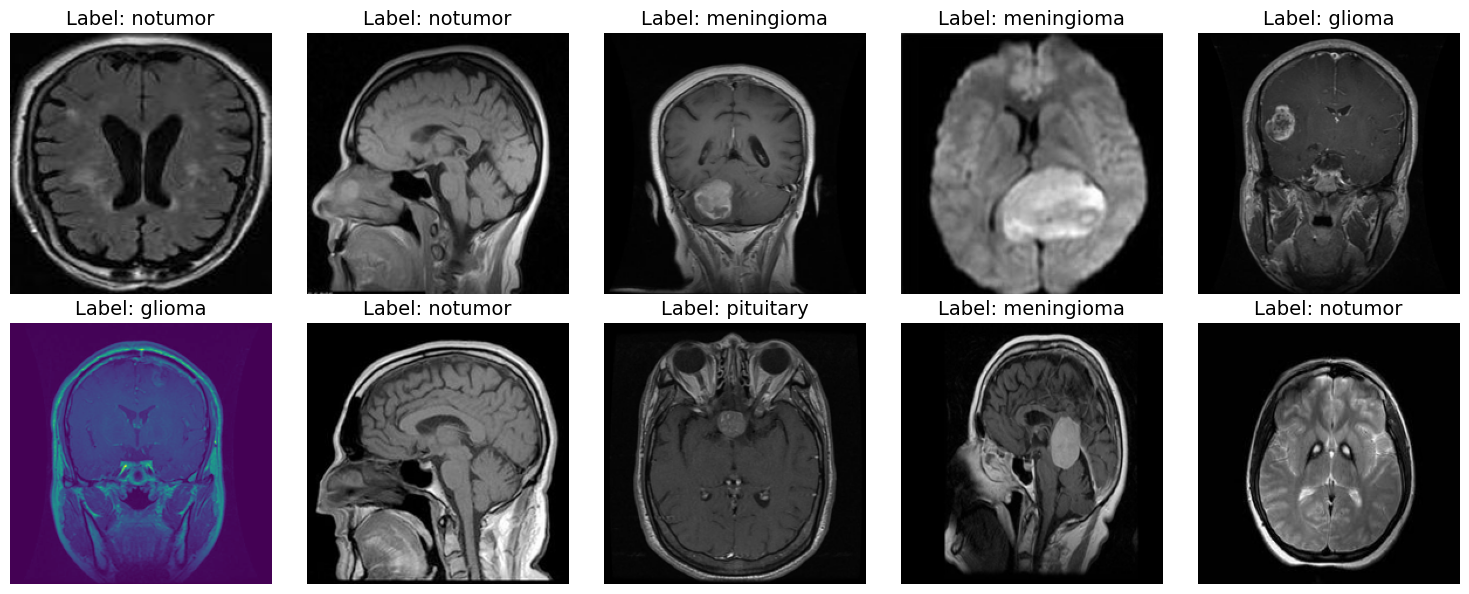

In [4]:
import matplotlib.pyplot as plt

# image size for EfficientNetB0
IMAGE_SIZE = 224

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

# Loop through the random indices and display images
for i, idx in enumerate(random_indices):
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))

    # Display image
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=14)

plt.tight_layout()
plt.show()


# Image Preprocessing (Helper Functions)

In [5]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
from PIL import Image, ImageEnhance
import numpy as np
import os
import random

# Label Mapping (global)
class_names = sorted(os.listdir(train_dir))
label_map = {label: idx for idx, label in enumerate(class_names)}

# ✅ Label encoder
def encode_label(labels):
    return [label_map[label] for label in labels]

# ✅ Augmentation Function
def augment_image(image):
    try:
        # Random Brightness and Contrast
        if random.random() > 0.5:
            image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
        if random.random() > 0.5:
            image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))

        # Random Horizontal Flip
        if random.random() > 0.5:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)

        # Random Rotation
        if random.random() > 0.5:
            image = image.rotate(random.uniform(-10, 10))
    except Exception as e:
        print(f"⚠️ Augmentation error: {e}")
    return image

# ✅ Open & Preprocess Images
def open_images(paths):
    images = []
    for path in paths:
        try:
            img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
            img = augment_image(img)
            img = img_to_array(img)
            img = preprocess_input(img)  # EfficientNet expects preprocessed inputs
            images.append(img)
        except Exception as e:
            print(f"⚠️ Failed to load image: {path} - {e}")
    return np.array(images)

# ✅ Data Generator
def datagen(paths, labels, batch_size=12):
    while True:
        combined = list(zip(paths, labels))
        np.random.shuffle(combined)
        paths, labels = zip(*combined)

        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]
            batch_images = open_images(batch_paths)
            batch_encoded_labels = encode_label(batch_labels)
            yield np.array(batch_images), np.array(batch_encoded_labels)


# Model: EfficientNetB0 For Transfer Learning

Epoch 1/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 179s 751ms/step - loss: 0.9108 - sparse_categorical_accuracy: 0.6247 - val_loss: 0.3508 - val_sparse_categorical_accuracy: 0.8740
Epoch 2/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 148s 652ms/step - loss: 0.3476 - sparse_categorical_accuracy: 0.8709 - val_loss: 0.2500 - val_sparse_categorical_accuracy: 0.9011
Epoch 3/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 145s 639ms/step - loss: 0.2362 - sparse_categorical_accuracy: 0.9147 - val_loss: 0.2340 - val_sparse_categorical_accuracy: 0.9090
Epoch 4/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 146s 640ms/step - loss: 0.1901 - sparse_categorical_accuracy: 0.9267 - val_loss: 0.1746 - val_sparse_categorical_accuracy: 0.9309
Epoch 5/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 145s 637ms/step - loss: 0.1619 - sparse_categorical_accuracy: 0.9383 - val_loss: 0.1591 - val_sparse_categorical_accuracy: 0.9344
Epoch 6/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 145s 636ms/step - loss: 0.1541 - sparse_categorical_accuracy: 0.9404 - val_loss: 0.1402 - val_sparse_categoric

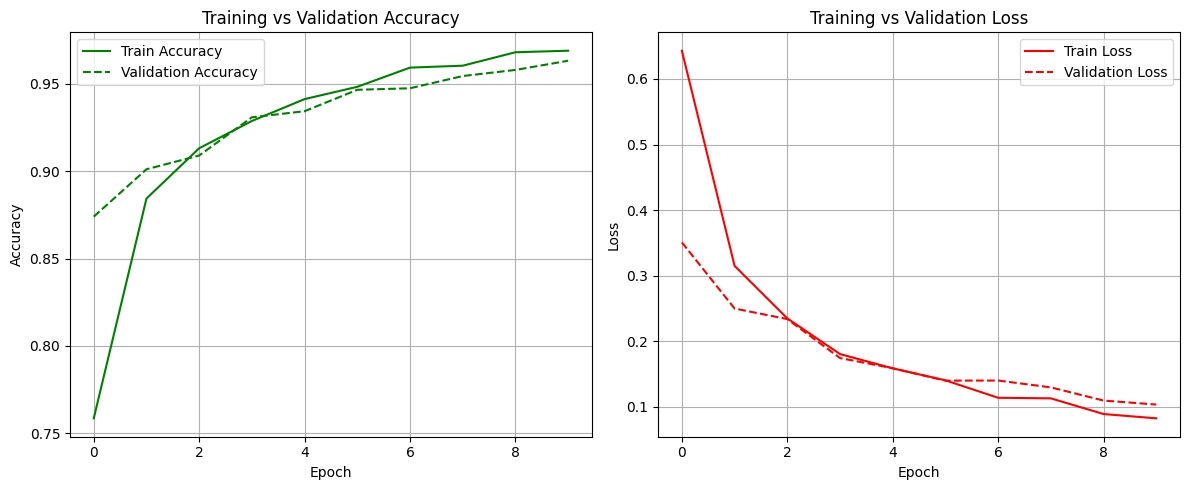

In [7]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import os

# Constants
IMAGE_SIZE = 224  # Updated from 128 to 224 for EfficientNetB0
NUM_CLASSES = len(os.listdir(train_dir))
batch_size = 20
epochs = 10

# 🔁 Fixed label mapping (global)
class_names = sorted(os.listdir(train_dir))
label_map = {label: idx for idx, label in enumerate(class_names)}

def encode_label(labels):
    return [label_map[label] for label in labels]

# 📦 Split training data into training and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels,
    test_size=0.2,
    random_state=42,
    stratify=train_labels
)

# ✅ Load EfficientNetB0 base model without the top classifier layers
base_model = EfficientNetB0(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers initially
base_model.trainable = False

# Optionally unfreeze last few layers for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# ✅ Build the full model
model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    base_model,
    GlobalAveragePooling2D(),      # More efficient than Flatten
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation='softmax')
])

# ✅ Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

# ✅ Train the model with validation
history = model.fit(
    datagen(train_paths, train_labels, batch_size=batch_size),
    steps_per_epoch=len(train_paths) // batch_size,
    epochs=epochs,
    validation_data=(open_images(val_paths), np.array(encode_label(val_labels)))
)

import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], 'g-', label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], 'g--', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'r-', label='Train Loss')
plt.plot(history.history['val_loss'], 'r--', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Train and Val Plots

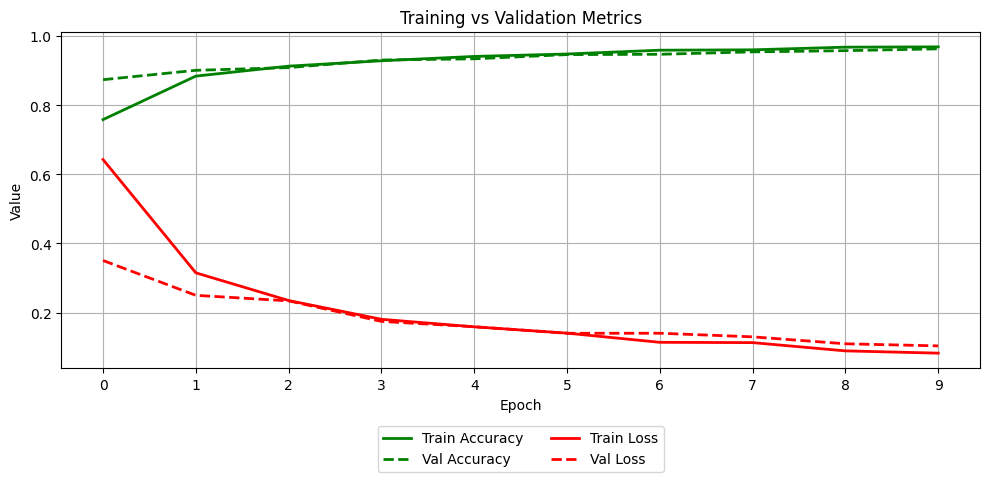

In [8]:
plt.figure(figsize=(10, 5))
plt.grid(True)

# Accuracy
plt.plot(history.history['sparse_categorical_accuracy'], 'g-', label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_sparse_categorical_accuracy'], 'g--', label='Val Accuracy', linewidth=2)

# Loss
plt.plot(history.history['loss'], 'r-', label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], 'r--', label='Val Loss', linewidth=2)

plt.title('Training vs Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.xticks(range(epochs))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.tight_layout()
plt.show()


# Model Classification Report

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)
test_labels_encoded = encode_label(test_labels)

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report: ")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 35s 829ms/step
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       300
           1       0.92      0.97      0.94       306
           2       0.99      1.00      0.99       405
           3       0.99      0.99      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



# Model Confusion Plot

Confusion Matrix: 
[[280  20   0   0]
 [  2 296   4   4]
 [  0   2 403   0]
 [  0   3   0 297]]


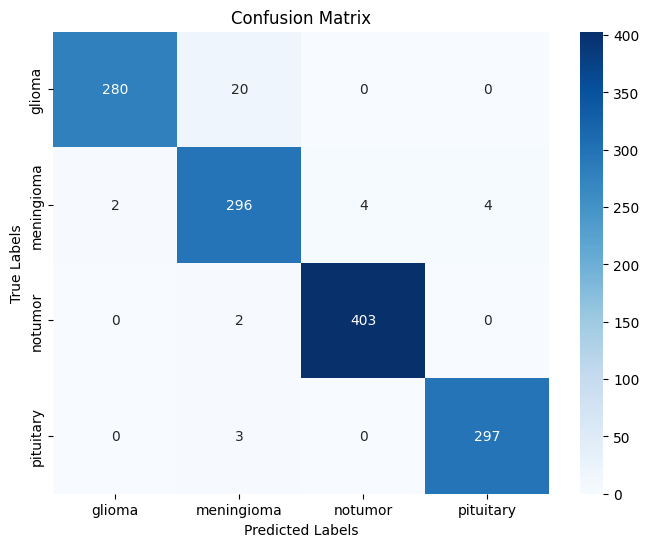

In [10]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix: ")
print(conf_matrix)

# PLot the Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# ROC Curve Plot

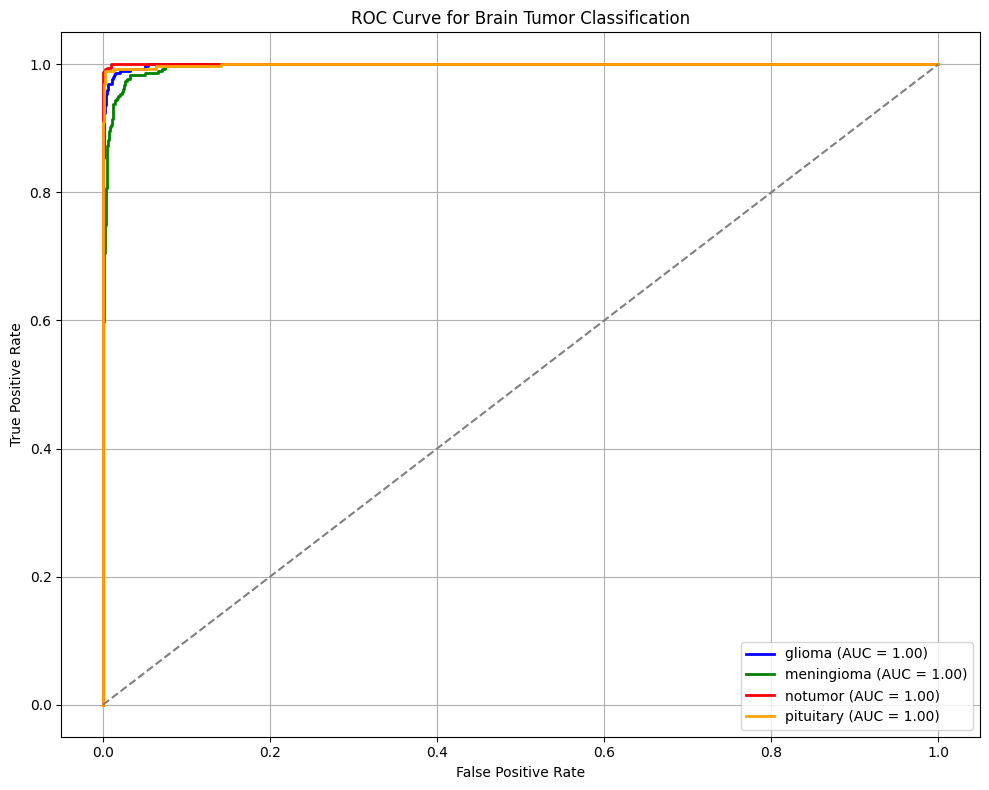

In [11]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# One-hot encode the true test labels
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(class_names)))

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'orange']

for i, color in zip(range(len(class_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve for Brain Tumor Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


# Save and Load Model

In [42]:
# Save the entire model
model.save('modelfinal.h5')

In [44]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('modelfinal.h5')

# MRI Tumor Detection System

In [53]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.efficientnet import preprocess_input

# Class Labels
class_labels = sorted(os.listdir(train_dir))

def detect_and_display(img_path, model, image_size=224):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and connfidence.
    """

    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = preprocess_input(img_to_array(img))
        img_array = np.expand_dims(img_array, axis=0) # Add batch dimensions

        # Make prediction
        predictions = model.predict(img_array)

        # 🔍 Debug: Print raw prediction probabilities
        print("Prediction Probabilities:")
        for i, prob in enumerate(predictions[0]):
            print(f"{class_labels[i]}: {prob:.4f}")
    
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()


    except Exception as e:
        print("Error processing the image: ", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Prediction Probabilities:
glioma: 0.9412
meningioma: 0.0324
notumor: 0.0049
pituitary: 0.0215


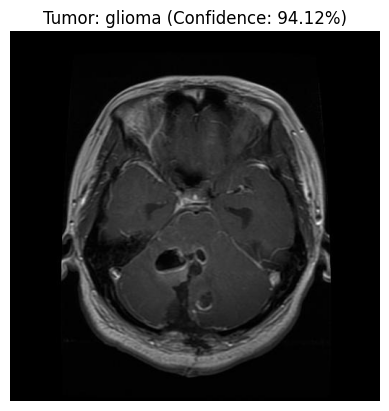

In [56]:
# Example usage
detect_and_display("MRI Images/Testing/glioma/Te-gl_0020.jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Prediction Probabilities:
glioma: 0.0008
meningioma: 0.9965
notumor: 0.0000
pituitary: 0.0026


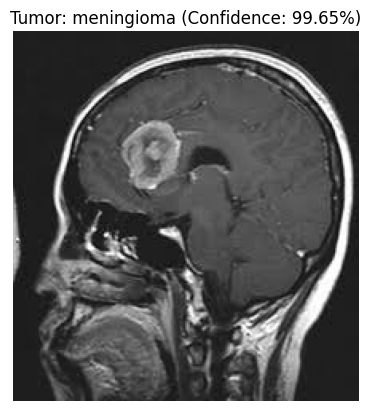

In [57]:
# Example usage
detect_and_display("MRI Images/Testing/meningioma/Te-me_0060.jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Prediction Probabilities:
glioma: 0.0751
meningioma: 0.0004
notumor: 0.9243
pituitary: 0.0002


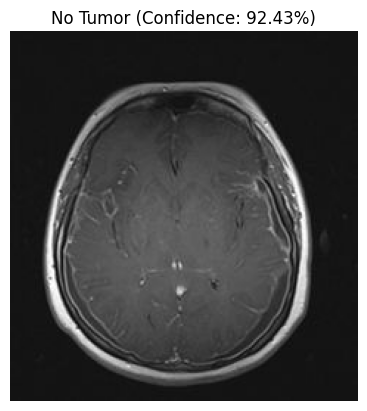

In [58]:
# Example usage
detect_and_display("MRI Images/Testing/notumor/Te-no_0054.jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Prediction Probabilities:
glioma: 0.0015
meningioma: 0.0064
notumor: 0.0008
pituitary: 0.9914


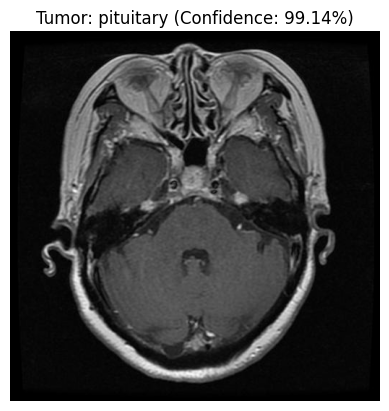

In [59]:
# Example usage
detect_and_display("MRI Images/Testing/pituitary/Te-pi_0020.jpg", model)

In [12]:
import json, numpy as np

# Save training history
with open("history.json", "w") as f:
    json.dump(history.history, f)

# Save test predictions and labels
np.save("test_predictions.npy", test_predictions)
np.save("test_labels.npy", test_labels_encoded)
